In [2]:
TICKER = 'SPY'
DATE_FILTER = '2023-01-01'
TREASURY_MATURITY = '2year'

In [3]:
import requests
import csv
import pandas as pd
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import time
import random
from datetime import datetime, date

In [4]:
def get_data(ticker, size='full', date_filter=None):
    """ Retrieve time series data for the price of a security in data frame format
        Sorts so that first date is first index, filters on date if given, renames columns and converts datatypes

    Args:
        ticker (string): The ticker for the security to pull data from
        size (string): 'full' since 1999, 'compact' is last 100 trading days
        date_filter (date string): Filters  data to  keep data only the filter date onward

    Returns:
        df: A dataframe with open, close, high, low, adj close price, volume, split coef, date
    """
    key='&apikey=ZKMMTO1ATDBLXH2K' # API Key
    api_ticker=f'&symbol={ticker}' # Ticker
    endpoint='function=TIME_SERIES_DAILY_ADJUSTED' # Called 'function', the dataset we want
    size=f'&outputsize={size}'
    web='https://www.alphavantage.co/query?'
    url =web+endpoint+api_ticker+size+key

    r = requests.get(url)
    # print(r.status_code) # 200 good, 400 bad
    data = r.json()

    # print(data.keys()) #printing the keys
    meta = data['Meta Data']
    time_series_data = data['Time Series (Daily)']

    ts_df = pd.DataFrame.from_dict(time_series_data, orient='index').reset_index().rename(columns={'index': 'Date'})
    clean_cols_dict = {'1. open': 'Open', '2. high': 'High', '3. low': 'Low', '4. close': 'Close', # Dictionary to convert the names of the columns
                '5. adjusted close': 'Adj Close', '6. volume': 'Volume', '7. dividend amount': 'Dividend', '8. split coefficient': 'Split Coef'}
    ts_df = ts_df.rename(columns=clean_cols_dict)

    ts_df['Date'] = pd.to_datetime(ts_df['Date'])
    if date_filter is not None:
        date_filter = pd.to_datetime(date_filter)
        ts_df = ts_df[ts_df['Date'] >= date_filter]


    ts_df = ts_df.sort_values(by='Date', ascending=True).reset_index().drop(columns='index')
    ts_df['Adj Close'] = ts_df['Adj Close'].astype('float').round(4)
    ts_df['Ticker'] = ticker
    
    return ts_df

In [5]:
def get_treasury(maturity='2year', interval='daily', date_filter=None):
    """ Retrieve the treasury rate of a given maturity over a specified interval and time as a df

    Args:
        maturity (str, optional): The description of the bond. Defaults to '2year'.
        interval (str, optional): How often are we retreiving prices. Defaults to 'daily'.
        date_filter (_type_, optional): The first date you want to keep. Defaults to None.

    Returns:
       df : with two columns, date and rate
    """

    key='&apikey=ZKMMTO1ATDBLXH2K'
    endpoint='function=TREASURY_YIELD'
    maturity=f'&maturity={maturity}'
    interval=f'&interval={interval}'
    web='https://www.alphavantage.co/query?'
    url = web + endpoint + maturity + interval + key

    r = requests.get(url)
    data = r.json()['data']

    df = pd.DataFrame(data, columns=['date', 'value'])
    df = df.dropna()
    df['Rate'] = pd.to_numeric(df['value'], errors='coerce')
    df['Date'] = pd.to_datetime(df['date'])
    
    if date_filter is not None:
        date_filter = pd.to_datetime(date_filter)
        df = df[df['Date'] >= date_filter]

    df = df.sort_values(by='Date', ascending=True).reset_index().drop(columns='index')

    df = df[['Date', 'Rate']]
    df = df.dropna()
    


    return df

In [6]:
def calculate_returns(df, frequency=1):
    """ Calculate the log returns of a security given a df with its prices over a time period

    Args:
        df (dataframe): A dataframe with columns Date, Ticker, Volume, and Adj Close
        frequency (int, optional): How often you want to calculate a return Defaults to 1.

    Returns:
        df: The dataframe from the start with an additional 'Log Return' column which is the log return over the interval for each row
    """
    returns_df = df[['Date', 'Ticker', 'Volume', 'Adj Close']].copy()
    returns_df['Adj Close'] = returns_df['Adj Close'].astype('float')
    returns_df['Log Return'] = np.log(
        returns_df['Adj Close'] / returns_df['Adj Close'].shift(frequency)
    )
    returns_df = returns_df.dropna()

    # If frequency > 1, keep only every `frequency`-th row
    if frequency > 1:
        returns_df = returns_df.iloc[frequency-1::frequency].reset_index(drop=True)

    return returns_df



In [7]:
def time_in_years(start_date, end_date, convention="30U/360"):
    """
    Compute year fraction using 30/360 convention.

    Accepted inputs for start_date/end_date:
      - 'YYYY-MM-DD' string
      - datetime.datetime
      - datetime.date

    convention:
      - "30U/360" (US/NASD)
      - "30E/360" (European)
    """
    def _to_date(d):
        if isinstance(d, datetime):
            return d.date()
        if isinstance(d, date):
            return d
        if isinstance(d, str):
            return datetime.strptime(d, "%Y-%m-%d").date()
        raise TypeError(
            f"Unsupported date type: {type(d).__name__}. "
            "Use YYYY-MM-DD string, datetime, or date."
        )

    d1 = _to_date(start_date)
    d2 = _to_date(end_date)

    y1, m1, day1 = d1.year, d1.month, d1.day
    y2, m2, day2 = d2.year, d2.month, d2.day

    if convention == "30U/360":
        # US/NASD 30/360
        if day1 == 31:
            day1 = 30
        if day2 == 31 and day1 == 30:
            day2 = 30
    elif convention == "30E/360":
        # European 30/360
        day1 = min(day1, 30)
        day2 = min(day2, 30)
    else:
        raise ValueError("Invalid convention. Use '30U/360' or '30E/360'.")

    return (360 * (y2 - y1) + 30 * (m2 - m1) + (day2 - day1)) / 360



In [8]:
def returns_rf_moments(df):
    returns_mean = df['Log Return'].mean()
    returns_var = df['Log Return'].var() # By default is sample variance
    rf_mean = df['Rate'].mean()

    returns_mean = returns_mean * 252
    returns_var = returns_var * 252
    rf_mean = np.log(1 + rf_mean/100)

    return returns_mean, returns_var, rf_mean


In [9]:
def binomial_parameters(mean, var, div, rf, T, n):

    sigma = np.sqrt(var)
    h = T / n

    # Forward Tree
    u_fwd = math.exp((rf - div) * h + sigma * np.sqrt(h)) # Positive return
    d_fwd = math.exp((rf - div) * h - sigma * np.sqrt(h)) # Negative Return
    q_fwd = (math.exp((rf - div) * h) - d_fwd) / (u_fwd - d_fwd)

    # Cox Ross Rubenstein (CCR)
    u_ccr = math.exp(sigma * np.sqrt(h)) 
    d_ccr = math.exp(-sigma * np.sqrt(h))
    q_ccr = (math.exp((rf - div) * h) - d_ccr) / (u_ccr - d_ccr)

    # JR
    u_jr = math.exp((rf - div - 0.5 * sigma ** 2) * h + sigma * np.sqrt(h)) 
    d_jr = math.exp((rf - div - 0.5 * sigma ** 2) * h - sigma * np.sqrt(h)) 
    q_jr = (math.exp((rf - div) * h) - d_jr) / (u_jr - d_jr)

    result = {'steps': n}

    fwd = {'u': u_fwd, 'd': d_fwd, 'q': q_fwd}
    ccr = {'u': u_ccr, 'd': d_ccr, 'q': q_ccr}
    jr = {'u': u_jr, 'd': d_jr, 'q': q_jr}

    result['fwd'] = fwd
    result['ccr'] = ccr
    result['jr'] = jr

    return result



In [51]:
def simulate_price_binom(params, S0, model='ccr', seed=4460):

    n = params['steps']
    params = params[model]
    prices = [S0]

    np.random.seed(seed)
    sequence = np.random.choice([0, 1], size=n, p=[1 - params['q'], params['q']])
    for i in range(n): # We want to generate a price (and subsequent price move from T-1 price) for each step
        if i == 0:
            step_price = S0 * (sequence[i] * params['u'] + (1 - sequence[i]) * params['d']) # Computing the first price
        else:
            step_price = prices[i] * (sequence[i] * params['u'] + (1 - sequence[i])* params['d']) # Computing subsequent prices based on T-1 price
        prices.append(step_price) # Adding the price for the given step to our list

    return prices

In [49]:
def repeat_simulations_binom(N, params, S0, model='ccr', export='N'):
    prices_list = []

    for i in range(N):
        prices = simulate_price_binom(params, S0, model=model, seed=i)
        prices_list.append(prices)

    if export == 'Y':
        df = pd.DataFrame(prices_list)
        df.to_csv('Prices Simulation.csv')

    return prices_list



In [34]:
def simulate_price_gbm(T, n, var, div, rf, S0, seed=1000):

    dt = T / n
    bTrajectory = [0]       # Stores our movement

    random.seed(seed)
    for t in range(1, n+1): # From 1 -> last step
        step = (T / n) * t
        dW = random.gauss(0, dt**0.5) # Creating delta = w_t - w_(t-1)
        bTrajectory.append(bTrajectory[t-1] + dW)

    drift = rf - div
    sigma = np.sqrt(var)

    prices = [S0] # List which includes the initial price estimate to start

    for i in range(1, n+1): # count from 1 to len of bTrajectory, up by 1 each time
        St = S0 * np.exp((drift - 0.5 * sigma**2) * (i * dt) + sigma * bTrajectory[i]) # GBM price given W_t
        prices.append(St) # Adding each step to our list of prices

    return prices

In [35]:
def repeat_simulations_gbm(N, T, n, var, div, rf, S0, export='N'):
    prices_list = []

    for i in range(N):
        prices = simulate_price_gbm(T, n, var, div, rf, S0, seed=i)
        prices_list.append(prices)

    if export == 'Y':
        df = pd.DataFrame(prices_list)
        df.to_csv('GBM Prices Simulation.csv')

    return prices_list

In [36]:
def price_european_option_from_simulations(prices_list, K, T, rf, option_type="call", rf_is_percent=False):
    """
    Price a European call/put from simulated price paths.

    prices_list: output of repeat_simulations(...) -> list of paths
    K: strike price
    T: time to maturity in years (from time_in_years)
    rf: average risk-free rate (from returns_rf_moments)
    option_type: "call" or "put"
    rf_is_percent: set True if rf is in percent (e.g., 4.5 for 4.5%)
    """
    
    if len(prices_list) == 0:
        raise ValueError("prices_list is empty.")

    opt = option_type.lower()
    if opt not in ("call", "put"):
        raise ValueError("option_type must be 'call' or 'put'.")

    # r = risk free rate converted to decimal form
    r = rf / 100.0 if rf_is_percent else rf

    # List of the last price from each path
    ST = np.array([path[-1] for path in prices_list], dtype=float) 

    # Lists of the profit for each path
    if opt == "call":
        payoffs = np.maximum(ST - K, 0.0) # We want (last price - K) which is profit for a call
    else:
        payoffs = np.maximum(K - ST, 0.0) # We want (K - last price) which is profit for a put

    price = math.exp(-r * T) * np.mean(payoffs)
    std_err = math.exp(-r * T) * np.std(payoffs, ddof=1) / np.sqrt(len(payoffs))

    return {
        "price": float(price),
        "std_error": float(std_err),
        "n_sims": int(len(payoffs))
    }


In [37]:
ticker_data = get_data(TICKER, size='full', date_filter=DATE_FILTER)
ticker_data

,Date,Open,High,Low,Close,Adj Close,Volume,Dividend,Split Coef,Ticker
0,2023-01-03,384.37,386.43,377.831,380.82,366.0455,74850731,0.0000,1.0,SPY
1,2023-01-04,383.18,385.88,380.0,383.76,368.8714,85934098,0.0000,1.0,SPY
2,2023-01-05,381.72,381.84,378.76,379.38,364.6613,76970456,0.0000,1.0,SPY
3,2023-01-06,382.61,389.25,379.4127,388.08,373.0238,104189603,0.0000,1.0,SPY
4,2023-01-09,390.37,393.7,387.67,387.86,372.8123,73978071,0.0000,1.0,SPY
...,...,...,...,...,...,...,...,...,...,...
774,2026-02-04,690.35,691.45,681.76,686.19,686.1900,105204600,0.0000,1.0,SPY
775,2026-02-05,680.94,683.69,675.79,677.62,677.6200,113610812,0.0000,1.0,SPY
776,2026-02-06,681.46,692.31,680.85,690.62,690.6200,89127566,0.0000,1.0,SPY
777,2026-02-09,689.42,695.87,688.34,693.95,693.9500,73885192,0.0000,1.0,SPY


In [38]:
returns_df = calculate_returns(ticker_data, frequency=1)
returns_df 

,Date,Ticker,Volume,Adj Close,Log Return
1,2023-01-04,SPY,85934098,368.8714,0.007690
2,2023-01-05,SPY,76970456,364.6613,-0.011479
3,2023-01-06,SPY,104189603,373.0238,0.022673
4,2023-01-09,SPY,73978071,372.8123,-0.000567
5,2023-01-10,SPY,65358094,375.4268,0.006988
...,...,...,...,...,...
774,2026-02-04,SPY,105204600,686.1900,-0.004856
775,2026-02-05,SPY,113610812,677.6200,-0.012568
776,2026-02-06,SPY,89127566,690.6200,0.019003
777,2026-02-09,SPY,73885192,693.9500,0.004810


In [39]:
treas_df = get_treasury(maturity=TREASURY_MATURITY, date_filter=DATE_FILTER)
treas_df

,Date,Rate
1,2023-01-03,4.40
2,2023-01-04,4.36
3,2023-01-05,4.45
4,2023-01-06,4.24
5,2023-01-09,4.19
...,...,...
806,2026-02-03,3.57
807,2026-02-04,3.57
808,2026-02-05,3.47
809,2026-02-06,3.50


In [40]:
combined_df = pd.merge(returns_df, treas_df, how='inner', on='Date')
combined_df

,Date,Ticker,Volume,Adj Close,Log Return,Rate
0,2023-01-04,SPY,85934098,368.8714,0.007690,4.36
1,2023-01-05,SPY,76970456,364.6613,-0.011479,4.45
2,2023-01-06,SPY,104189603,373.0238,0.022673,4.24
3,2023-01-09,SPY,73978071,372.8123,-0.000567,4.19
4,2023-01-10,SPY,65358094,375.4268,0.006988,4.24
...,...,...,...,...,...,...
767,2026-02-03,SPY,105889540,689.5300,-0.008491,3.57
768,2026-02-04,SPY,105204600,686.1900,-0.004856,3.57
769,2026-02-05,SPY,113610812,677.6200,-0.012568,3.47
770,2026-02-06,SPY,89127566,690.6200,0.019003,3.50


In [41]:
returns_mean, returns_var, rf_mean = returns_rf_moments(combined_df)
returns_mean, returns_var, rf_mean

(np.float64(0.19802527639518971),
 np.float64(0.02310657696475635),
 np.float64(0.04144907247716836))

In [42]:
T = time_in_years('2026-2-11', '2026-03-31')
T

0.1388888888888889

In [43]:
binom_params = binomial_parameters(returns_mean, returns_var, 0.0115, rf_mean, T, 2000)
binom_params

{'steps': 2000,
 'fwd': {'u': 1.0012696223908493,
  'd': 0.9987361418338282,
  'q': 0.49968331571607233},
 'ccr': {'u': 1.0012675399557585,
  'd': 0.9987340646678564,
  'q': 0.5005042429509187},
 'jr': {'u': 1.0012688190608383,
  'd': 0.9987353405364576,
  'q': 0.5000000000847519}}

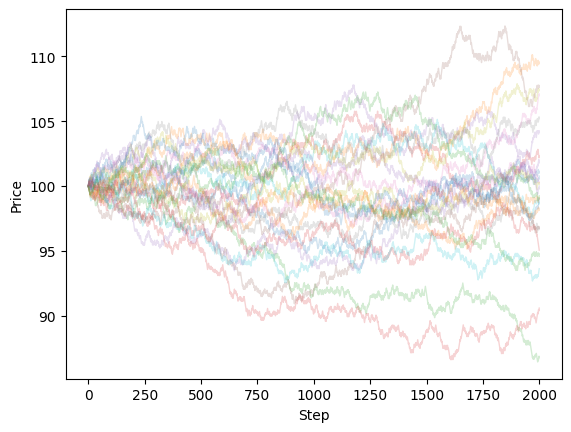

In [52]:
prices_list = repeat_simulations_binom(25, binom_params, 100, model='jr')
steps = range(len(prices_list[0]))

for series in prices_list:
    plt.plot(steps, series, alpha=0.2, linewidth=1)

plt.xlabel('Step')
plt.ylabel('Price')
plt.show()

In [53]:
prices_list = repeat_simulations_binom(2000, binom_params, 691.5, model="jr")
result_call = price_european_option_from_simulations(prices_list, K=692, T=T, rf=rf_mean, option_type="call")
result_put  = price_european_option_from_simulations(prices_list, K=692, T=T, rf=rf_mean, option_type="put")

result_call, result_put


({'price': 16.427510550172606,
  'std_error': 0.5393639975969863,
  'n_sims': 2000},
 {'price': 15.027210140820607,
  'std_error': 0.4947175521125687,
  'n_sims': 2000})

In [55]:
prices_list_gbm = repeat_simulations_gbm(2000, T, 2000, returns_var, 0.0115, rf_mean, 691.5)
result_call = price_european_option_from_simulations(prices_list_gbm, K=692, T=T, rf=rf_mean, option_type="call")
result_put  = price_european_option_from_simulations(prices_list_gbm, K=692, T=T, rf=rf_mean, option_type="put")

result_call, result_put


({'price': 16.757156536408925,
  'std_error': 0.5576350074685363,
  'n_sims': 2000},
 {'price': 14.683370581405539,
  'std_error': 0.4700191705514162,
  'n_sims': 2000})

=== BINOMIAL (JR) MODEL ===
Mean terminal price: $693.41
Std dev terminal price: $39.79
Min: $567.52, Max: $862.04

=== GBM MODEL ===
Mean terminal price: $694.09
Std dev terminal price: $39.68
Min: $584.26, Max: $857.25

=== COMPARISON ===
Difference in mean: $0.68
Ratio of std devs: 0.997


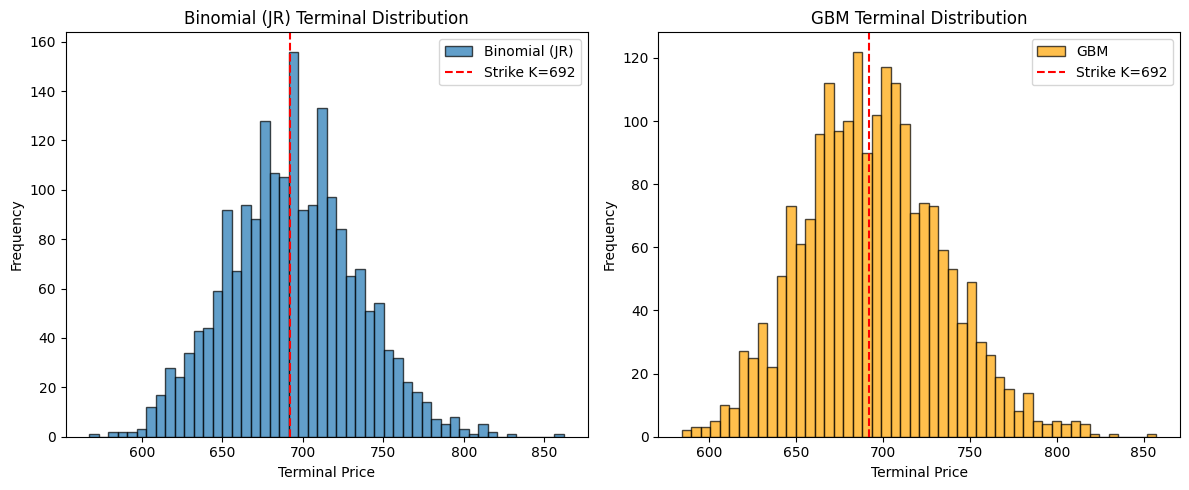

In [56]:
# Diagnostic: Compare terminal price distributions
terminal_prices_binom = [path[-1] for path in prices_list]
terminal_prices_gbm = [path[-1] for path in prices_list_gbm]

print("=== BINOMIAL (JR) MODEL ===")
print(f"Mean terminal price: ${np.mean(terminal_prices_binom):.2f}")
print(f"Std dev terminal price: ${np.std(terminal_prices_binom, ddof=1):.2f}")
print(f"Min: ${np.min(terminal_prices_binom):.2f}, Max: ${np.max(terminal_prices_binom):.2f}")

print("\n=== GBM MODEL ===")
print(f"Mean terminal price: ${np.mean(terminal_prices_gbm):.2f}")
print(f"Std dev terminal price: ${np.std(terminal_prices_gbm, ddof=1):.2f}")
print(f"Min: ${np.min(terminal_prices_gbm):.2f}, Max: ${np.max(terminal_prices_gbm):.2f}")

print("\n=== COMPARISON ===")
print(f"Difference in mean: ${np.mean(terminal_prices_gbm) - np.mean(terminal_prices_binom):.2f}")
print(f"Ratio of std devs: {np.std(terminal_prices_gbm, ddof=1) / np.std(terminal_prices_binom, ddof=1):.3f}")

# Plot distributions
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(terminal_prices_binom, bins=50, alpha=0.7, label='Binomial (JR)', edgecolor='black')
plt.axvline(692, color='red', linestyle='--', label='Strike K=692')
plt.xlabel('Terminal Price')
plt.ylabel('Frequency')
plt.title('Binomial (JR) Terminal Distribution')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(terminal_prices_gbm, bins=50, alpha=0.7, label='GBM', edgecolor='black', color='orange')
plt.axvline(692, color='red', linestyle='--', label='Strike K=692')
plt.xlabel('Terminal Price')
plt.ylabel('Frequency')
plt.title('GBM Terminal Distribution')
plt.legend()

plt.tight_layout()
plt.show()